# ***COVID*** Section

In [25]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import year, month, dayofmonth,col,avg
from pyspark.sql.window import Window
# extract data from Kagglehub using their API
dataset_dir = kagglehub.dataset_download("joebeachcapital/s-and-p500-index-stocks-daily-updated")

In [26]:
spark  = SparkSession.builder.appName("Analysis").getOrCreate()

data = spark.read.csv(dataset_dir, header=True, inferSchema=True)

# Data cleaning and preprocesing should be done here
data = data.dropna()

# No duplicates (Yay), if there were it would've printed them to console
data.exceptAll(data.dropDuplicates()).show()

+----+------+----+----+---+-----+---------+------+
|Date|Ticker|Open|High|Low|Close|Adj Close|Volume|
+----+------+----+----+---+-----+---------+------+
+----+------+----+----+---+-----+---------+------+



In [27]:

data = data.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Day", dayofmonth("Date"))

# Covid period
covid_condition = (
    (col("Year") == 2020) & (col("Month") <= 11) & (col("Month") >= 3)
)

filtered_data = data.filter(covid_condition)

# query whole table (to show we have loaded the data properly)
filtered_data.createOrReplaceTempView("stocks")
spark.sql("SELECT * FROM stocks").show()

# in new table for each ticker create aggregated averages of each column per month
aggregated_data = filtered_data.groupBy("Ticker", "Year", "Month")
aggregated_data = aggregated_data.agg(
    # Average each column per month
    *[avg(c).alias(f"avg_covid_{c}") for c in ["Open", "High", "Low", "Close", "Volume"]]
)

aggregated_data = aggregated_data.orderBy("Ticker", "Month")

aggregated_data.show()


+----------+------+----------+----------+----------+----------+---------+--------+----+-----+---+
|      Date|Ticker|      Open|      High|       Low|     Close|Adj Close|  Volume|Year|Month|Day|
+----------+------+----------+----------+----------+----------+---------+--------+----+-----+---+
|2020-03-02|   MMM| 126.53846| 128.28595| 124.05518|127.943146|106.03807| 9599455|2020|    3|  2|
|2020-03-03|   MMM| 127.45819| 128.76254| 120.76923|121.438126|100.64676| 9922614|2020|    3|  3|
|2020-03-04|   MMM| 122.92642| 128.76254|122.065216| 128.74582|106.70331| 6905465|2020|    3|  4|
|2020-03-05|   MMM| 126.08696| 129.05519| 125.04181| 126.59699|104.92238| 7040852|2020|    3|  5|
|2020-03-06|   MMM| 125.07525| 129.38127| 123.63712|  128.4699|106.47462| 8557500|2020|    3|  6|
|2020-03-09|   MMM| 122.56689| 124.96655|120.025085| 120.45151| 99.82907| 9800502|2020|    3|  9|
|2020-03-10|   MMM| 124.59866| 128.24414| 121.13712| 128.17726|106.23209| 6759433|2020|    3| 10|
|2020-03-11|   MMM| 

In [28]:
# First we are filtering the before-COVID period (1 year)
one_year_before_covid_condition = ((col("Year") == 2019) & (col("Month") <= 11) & (col("Month") >= 3))

before_filtered_data = data.filter(one_year_before_covid_condition)
before_filtered_data = before_filtered_data.groupBy("Ticker", "Year", "Month")
before_filtered_data = before_filtered_data.agg(
    # Apply avg to each column
    *[avg(c).alias(f"avg_before_covid_{c}") for c in ["Open", "High", "Low", "Close", "Volume"]]
)

# Registering the dataframes as temp views for SQL queries
before_filtered_data.createOrReplaceTempView("before_stocks")
aggregated_data.createOrReplaceTempView("during_stocks")

# ordering by ticker and month
before_filtered_data = before_filtered_data.orderBy("Ticker", "Month")

before_filtered_data.show()
aggregated_data.show()

# Performing the SQL query to join the two datasets (before and during COVID)
# Join before_filtered_data and during_filtered_data on Ticker and Year, Month
joined_data = spark.sql("""
    SELECT
        COALESCE(before_stocks.Ticker, during_stocks.Ticker) AS Ticker,
        before_stocks.Year AS before_year,
        before_stocks.Month AS before_month,
        before_stocks.avg_before_covid_Open AS before_open,
        before_stocks.avg_before_covid_High AS before_high,
        before_stocks.avg_before_covid_Low AS before_low,
        before_stocks.avg_before_covid_Close AS before_close,
        before_stocks.avg_before_covid_Volume AS before_volume,
        during_stocks.Year AS during_year,
        during_stocks.Month AS during_month,
        during_stocks.avg_covid_Open AS during_open,
        during_stocks.avg_covid_High AS during_high,
        during_stocks.avg_covid_Low AS during_low,
        during_stocks.avg_covid_Close AS during_close,
        during_stocks.avg_covid_Volume AS during_volume
    FROM before_stocks
    FULL JOIN during_stocks
    ON before_stocks.Ticker = during_stocks.Ticker
    AND before_stocks.Month = during_stocks.Month
""")

joined_data = joined_data.orderBy("Ticker", "before_year", "before_month")

joined_data.show()

+------+----+-----+---------------------+---------------------+--------------------+----------------------+-----------------------+
|Ticker|Year|Month|avg_before_covid_Open|avg_before_covid_High|avg_before_covid_Low|avg_before_covid_Close|avg_before_covid_Volume|
+------+----+-----+---------------------+---------------------+--------------------+----------------------+-----------------------+
|     A|2019|    3|    80.11809523809525|    80.64619047619047|    79.4757142857143|     80.04619047619049|     1562219.0476190476|
|     A|2019|    4|     79.2395238095238|     79.8952380952381|   78.43619047619048|     79.05857142857143|     1993633.3333333333|
|     A|2019|    5|    71.98772727272727|    73.06227272727273|               71.17|                72.145|     3512131.8181818184|
|     A|2019|    6|               70.934|    71.52950000000001|   70.29849999999999|               71.0035|              2046835.0|
|     A|2019|    7|                 71.8|    72.24636363636365|    70.974090

In [29]:
 # Queries

# Making Price Recovery (High 2019, Close 2020, Recovery Ratio) table
# Getting the highest 'High' for each company in 2019
data_2019 = joined_data.filter(col("before_year") == 2019)
high_2019 = data_2019.groupBy("Ticker").agg(F.max("before_high").alias("High_2019"))

# Getting the highest 'Close' for each company in 2020
data_2020 = joined_data.filter(col("during_year") == 2020)
close_2020 = data_2020.groupBy("Ticker").agg(F.max("during_close").alias("Close_2020"))

# Joining the two datasets on 'Ticker'
recovery_data = high_2019.join(close_2020, on="Ticker", how="inner")

# Calculating the Recovery Ratio
recovery_data = recovery_data.withColumn(
    "Recovery_Ratio", (col("Close_2020") / col("High_2019")) * 100
)

# Displaying and save the final table
recovery_data.show()


# Standard Deviation


# Calculating Monthly Returns for Before and During COVID periods
# Adding a column for the previous month's close price for each Ticker
joined_data = joined_data.withColumn(
    "prev_close",
    F.lag(joined_data["before_close"]).over(Window.partitionBy("Ticker").orderBy("before_year", "before_month"))
)

# Calculating Monthly Return (percentage change) for Before-COVID period
joined_data = joined_data.withColumn(
    "monthly_return_before",
    (joined_data["before_close"] - joined_data["prev_close"]) / joined_data["prev_close"]
)

# Calculate Monthly Return for During-COVID period
joined_data = joined_data.withColumn(
    "monthly_return_during",
    (joined_data["during_close"] - joined_data["prev_close"]) / joined_data["prev_close"]
)

# Calculating the Mean of Monthly Returns for each stock (before and during COVID)
monthly_return_mean_before = joined_data.groupBy("Ticker").agg(
    F.avg("monthly_return_before").alias("mean_monthly_return_before")
)

monthly_return_mean_during = joined_data.groupBy("Ticker").agg(
    F.avg("monthly_return_during").alias("mean_monthly_return_during")
)

# Calculating the Squared Differences from the Mean for both periods
joined_data = joined_data.join(monthly_return_mean_before, on="Ticker", how="left")
joined_data = joined_data.join(monthly_return_mean_during, on="Ticker", how="left")

joined_data = joined_data.withColumn(
    "squared_diff_before",
    (joined_data["monthly_return_before"] - joined_data["mean_monthly_return_before"])**2
)

joined_data = joined_data.withColumn(
    "squared_diff_during",
    (joined_data["monthly_return_during"] - joined_data["mean_monthly_return_during"])**2
)

# Calculating the Variance for both periods (Before and During COVID)
variance_data_before = joined_data.groupBy("Ticker").agg(
    F.avg("squared_diff_before").alias("variance_before")
)

variance_data_during = joined_data.groupBy("Ticker").agg(
    F.avg("squared_diff_during").alias("variance_during")
)

# Join variance data for both periods
joined_data = joined_data.join(variance_data_before, on="Ticker", how="left")
joined_data = joined_data.join(variance_data_during, on="Ticker", how="left")

# Calculating Standard Deviation for both periods (Before and During COVID)
joined_data = joined_data.withColumn(
    "standard_deviation_before", F.sqrt(joined_data["variance_before"])
)

joined_data = joined_data.withColumn(
    "standard_deviation_during", F.sqrt(joined_data["variance_during"])
)

# Selecting the results and showing one row per company
final_data = joined_data.select(
    "Ticker",
    "standard_deviation_before",
    "standard_deviation_during"
).distinct()

# Show the final result of the transformations
final_data.show()


# Queries for Positively Impacted Stocks
recovery_data.createOrReplaceTempView("recovery_view")

top_20_recovery = spark.sql("""
    SELECT Ticker, High_2019, Close_2020, Recovery_Ratio
    FROM recovery_view
    ORDER BY Recovery_Ratio DESC
    LIMIT 20
""")
top_20_recovery.show()

final_data.createOrReplaceTempView("std_dev_view")

combined_data = spark.sql("""
    SELECT
        std_dev_view.Ticker,
        std_dev_view.standard_deviation_before,
        std_dev_view.standard_deviation_during,
        recovery_view.High_2019,
        recovery_view.Close_2020,
        recovery_view.Recovery_Ratio
    FROM std_dev_view
    JOIN recovery_view
    ON std_dev_view.Ticker = recovery_view.Ticker
""")

combined_data.createOrReplaceTempView("combined_view")

lowest_20_std_dev = spark.sql("""
    SELECT
        Ticker,
        standard_deviation_before,
        standard_deviation_during,
        High_2019,
        Close_2020,
        Recovery_Ratio
    FROM combined_view
    WHERE standard_deviation_during IS NOT NULL
    ORDER BY standard_deviation_during ASC
    LIMIT 20
""")


# Queries for Negatively Impacted stocks
bottom_20_recovery = spark.sql("""
    SELECT Ticker, High_2019, Close_2020, Recovery_Ratio
    FROM recovery_view
    ORDER BY Recovery_Ratio ASC
    LIMIT 20
""")
bottom_20_recovery.show()

top_20_std_dev = spark.sql("""
    SELECT
        Ticker,
        standard_deviation_before,
        standard_deviation_during,
        High_2019,
        Close_2020,
        Recovery_Ratio
    FROM combined_view
    WHERE standard_deviation_during IS NOT NULL
    ORDER BY standard_deviation_during DESC
    LIMIT 20
""")

print("Top 20 Stocks by Standard Deviation During COVID:")
top_20_std_dev.show()

print("Lowest 20 Stocks by Standard Deviation During COVID:")
lowest_20_std_dev.show()



+------+------------------+------------------+------------------+
|Ticker|         High_2019|        Close_2020|    Recovery_Ratio|
+------+------------------+------------------+------------------+
|   GIS|55.038499999999985| 64.01952380952382|116.31771180087362|
|     K|       60.88450725| 65.24703757142854|107.16525519951307|
|   LEN| 60.43130434782609| 80.04772727272726|132.46069754178131|
|  SPGI|263.00200000000007|355.60904761904766|135.21153740999975|
|   AVY|132.36549999999997|           148.668|112.31627576672172|
|   RTX|       93.56607925| 66.48349999999999| 71.05513080478894|
|   CRL|143.53428571428572|           236.086|164.48056213547784|
|   MMM|  177.230449047619|       141.9234945| 80.07850528092236|
|   PPG|129.18749999999997|          142.1225|110.01257861635223|
|    RF|            16.807|            14.881| 88.54048908193015|
|   KKR|            29.633|37.680499999999995|127.15722336584211|
|   AXP|127.40999999999998|111.18850000000002| 87.26826779687626|
|   CDW|  

In [30]:
joined_data.createOrReplaceTempView("joined_data_view")
draw_down_query = spark.sql("""
    SELECT
        Ticker,
        (MAX(before_high) - MIN(before_low)) / MAX(before_high) AS draw_down_before_covid,
        (MAX(during_high) - MIN(during_low)) / MAX(during_high) AS draw_down_during_covid
    FROM joined_data_view
    GROUP BY Ticker
""")

draw_down_query.createOrReplaceTempView("draw_down_view")

top_10_draw_down = spark.sql("""
    SELECT Ticker, draw_down_before_covid, draw_down_during_covid
    FROM draw_down_view
    WHERE draw_down_before_covid IS NOT NULL
    ORDER BY draw_down_during_covid DESC
    LIMIT 10
""")
print("Top 10 Stocks by Drawdown During COVID:")
top_10_draw_down.show()

lowest_10_draw_down = spark.sql("""
    SELECT Ticker, draw_down_before_covid, draw_down_during_covid
    FROM draw_down_view
    WHERE draw_down_before_covid IS NOT NULL
    ORDER BY draw_down_during_covid ASC
    LIMIT 10
""")
print("Lowest 10 Stocks by Drawdown During COVID:")
lowest_10_draw_down.show()


Top 10 Stocks by Drawdown During COVID:
+------+----------------------+----------------------+
|Ticker|draw_down_before_covid|draw_down_during_covid|
+------+----------------------+----------------------+
|  TSLA|    0.3885103867761385|     0.775303930737131|
|   CZR|    0.2388509376586018|    0.7554210315994716|
|  MRNA|    0.4809378721956821|    0.7275218360981157|
|  ENPH|      0.73172814173664|    0.7197186376349817|
|  CRWD|    0.4611765901239585|    0.6702482635280957|
|   FCX|    0.3152173913043479|    0.6592701376910142|
|  TRGP|   0.16663166946119332|    0.6321112869451238|
|  ALGN|    0.4523911083220971|    0.6219837733583451|
|  BLDR|    0.4722065935814591|    0.6212813059375085|
|   EQT|    0.5598131602531027|    0.6116520986452126|
+------+----------------------+----------------------+

Lowest 10 Stocks by Drawdown During COVID:
+------+----------------------+----------------------+
|Ticker|draw_down_before_covid|draw_down_during_covid|
+------+----------------------+-----

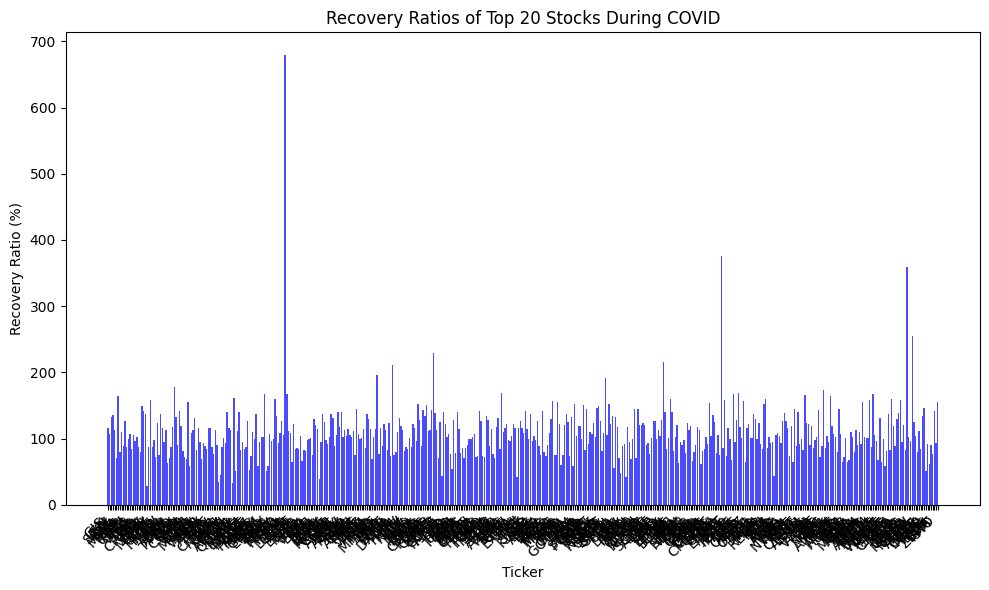

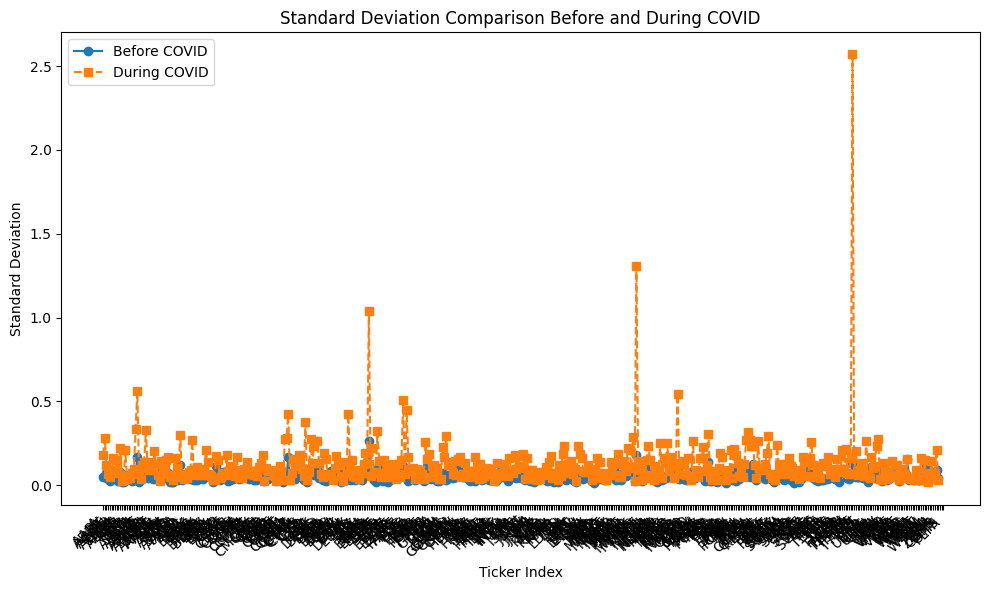

In [31]:
recovery_data_pd = recovery_data.toPandas()

recovery_data_pd["Ticker"] = recovery_data_pd["Ticker"].astype(str)
recovery_data_pd["Recovery_Ratio"] = pd.to_numeric(recovery_data_pd["Recovery_Ratio"], errors="coerce")

# Graph for Price Recovery
plt.figure(figsize=(10, 6))
x = recovery_data_pd["Ticker"]
y = recovery_data_pd["Recovery_Ratio"]
plt.bar(x, y, color='blue', alpha=0.7)
plt.title("Recovery Ratios of Top 20 Stocks During COVID")
plt.xlabel("Ticker")
plt.ylabel("Recovery Ratio (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

final_data_pd = final_data.toPandas()

final_data_pd["Ticker"] = final_data_pd["Ticker"].astype(str)
final_data_pd["standard_deviation_before"] = pd.to_numeric(final_data_pd["standard_deviation_before"], errors="coerce")
final_data_pd["standard_deviation_during"] = pd.to_numeric(final_data_pd["standard_deviation_during"], errors="coerce")

plt.figure(figsize=(10, 6))
x = range(len(final_data_pd["Ticker"]))
y1 = final_data_pd["standard_deviation_before"]
y2 = final_data_pd["standard_deviation_during"]
plt.plot(x, y1, label='Before COVID', marker='o', linestyle='-')
plt.plot(x, y2, label='During COVID', marker='s', linestyle='--')
plt.title("Standard Deviation Comparison Before and During COVID")
plt.xlabel("Ticker Index")
plt.ylabel("Standard Deviation")
plt.xticks(x, final_data_pd["Ticker"], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()





# Financial Crisis 2008

In [32]:
# Analysis for the 2 years before (so the years 2004-2006) the Financial crisis (which happened during 2007 to 2009)

pre_financial_crisis = (
    (col("Year") == 2005) & (col("Month") >= 1) & (col("Month") <= 12) |
    (col("Year") == 2004) & (col("Month") >=2) & (col("Month") <= 12) |
    (col("Year") == 2006) & (col("Month") >= 1) & (col("Month") <= 4)
)


filtered_data = data.filter(pre_financial_crisis)

filtered_data.createOrReplaceTempView("stocks")



Average_volume = spark.sql("""
  SELECT Ticker, AVG(Volume) AS avg_volume
  FROM stocks
  GROUP BY Ticker
""")



Daily_return = spark.sql("""
  SELECT Ticker, AVG((Close - Open) / Open) AS avg_daily_return
  FROM stocks
  GROUP BY Ticker
""")


VWAP = spark.sql("""
  SELECT Ticker, SUM(Close * Volume) / SUM(Volume) AS vwap
  FROM stocks
  GROUP BY Ticker
""")


Draw_Down = spark.sql("""
  SELECT Ticker, (MAX(close) - MIN(close))/MAX(close) AS draw_down
  FROM stocks
  GROUP BY Ticker
""")


volatility = spark.sql("""
    SELECT Ticker,STDDEV((Close - Open) / Open) AS volatility
    FROM stocks
    GROUP BY Ticker
""")


top_5_best  = Daily_return.orderBy(Daily_return["avg_daily_return"].desc()).limit(5)
top_5_worst = Daily_return.orderBy(Daily_return["avg_daily_return"].asc()).limit(5)

top_5_best_vol = Average_volume.orderBy(Average_volume["avg_volume"].desc()).limit(5)
top_5_worst_vol = Average_volume.orderBy(Average_volume["avg_volume"].asc()).limit(5)

top_5_best_vwap = VWAP.orderBy(VWAP["vwap"].desc()).limit(5)
top_5_worst_vwap = VWAP.orderBy(VWAP["vwap"].asc()).limit(5)

top_5_drawdown = Draw_Down.orderBy(Draw_Down["draw_down"].desc()).limit(5)
top_5_worst_drawdown = Draw_Down.orderBy(Draw_Down["draw_down"].asc()).limit(5)

top_5_volatility = volatility.orderBy(volatility["volatility"].desc()).limit(5)
top_5_worst_volatility = volatility.orderBy(volatility["volatility"].asc()).limit(5)

print("Top 5 best (Daily_Return) performing stocks:")
top_5_best.show()
print("Top 5 worst (Daily_Return) performing stocks:")
top_5_worst.show()


print("Top 5 best (Volume) performing stocks:")
top_5_best_vol.show()
print("Top 5 worst (Volume) performing stocks:")
top_5_worst_vol.show()

print("Top 5 best (VWAP) performing stocks:")
top_5_best_vwap.show()
print("Top 5 worst (VWAP) performing stocks:")
top_5_worst_vwap.show()


print("Top 5 Highest (Draw Down):")
top_5_drawdown.show()
print("Top 5 Lowest (Draw Down):")
top_5_worst_drawdown.show()

print("Top 5 Highest (Volatility):")
top_5_volatility.show()
print("Top 5 Lowest (Volatility):")
top_5_worst_volatility.show()


Top 5 best (Daily_Return) performing stocks:
+------+--------------------+
|Ticker|    avg_daily_return|
+------+--------------------+
|   LYV|0.008370398466324997|
|   UAL|0.008198232738556693|
|  MPWR|0.003654272809060...|
|  EQIX|0.003401522922906...|
|   AMP|0.003093945853753...|
+------+--------------------+

Top 5 worst (Daily_Return) performing stocks:
+------+--------------------+
|Ticker|    avg_daily_return|
+------+--------------------+
|  AXON|-0.00483108615534...|
|   TER|-0.00207461435264...|
|  SWKS|-0.00197063764000...|
|  PARA|-0.00173160876222...|
|     F|-0.00161944143459...|
+------+--------------------+

Top 5 best (Volume) performing stocks:
+------+--------------------+
|Ticker|          avg_volume|
+------+--------------------+
|  AAPL| 5.817455299964602E8|
|  NVDA| 5.711211947610619E8|
|  GOOG|  4.35870477793911E8|
| GOOGL| 4.338085862107728E8|
|  AMZN|1.5043093805309734E8|
+------+--------------------+

Top 5 worst (Volume) performing stocks:
+------+---------

In [33]:
# Analysis Section of the financial crisis

financial_crisis = (
    (col("Year") == 2008) & (col("Month") >= 1) & (col("Month") <= 12) |
    (col("Year") == 2007) & (col("Month") >=2) & (col("Month") <= 12) |
    (col("Year") == 2009) & (col("Month") >= 1) & (col("Month") <= 4)
)


filtered_data = data.filter(financial_crisis)

filtered_data.createOrReplaceTempView("stocks")


Average_volume = spark.sql("""
  SELECT Ticker, AVG(Volume) AS avg_volume
  FROM stocks
  GROUP BY Ticker
""")



Daily_return = spark.sql("""
  SELECT Ticker, AVG((Close - Open) / Open) AS avg_daily_return
  FROM stocks
  GROUP BY Ticker
""")


VWAP = spark.sql("""
  SELECT Ticker, SUM(Close * Volume) / SUM(Volume) AS vwap
  FROM stocks
  GROUP BY Ticker
""")


Draw_Down = spark.sql("""
  SELECT Ticker, (MAX(close) - MIN(close))/MAX(close) AS draw_down
  FROM stocks
  GROUP BY Ticker
""")


volatility = spark.sql("""
    SELECT Ticker,STDDEV((Close - Open) / Open) AS volatility
    FROM stocks
    GROUP BY Ticker
""")





top_5_best  = Daily_return.orderBy(Daily_return["avg_daily_return"].desc()).limit(5)
top_5_worst = Daily_return.orderBy(Daily_return["avg_daily_return"].asc()).limit(5)

top_5_best_vol = Average_volume.orderBy(Average_volume["avg_volume"].desc()).limit(5)
top_5_worst_vol = Average_volume.orderBy(Average_volume["avg_volume"].asc()).limit(5)

top_5_best_vwap = VWAP.orderBy(VWAP["vwap"].desc()).limit(5)
top_5_worst_vwap = VWAP.orderBy(VWAP["vwap"].asc()).limit(5)

top_5_drawdown = Draw_Down.orderBy(Draw_Down["draw_down"].desc()).limit(5)
top_5_worst_drawdown = Draw_Down.orderBy(Draw_Down["draw_down"].asc()).limit(5)

top_5_volatility = volatility.orderBy(volatility["volatility"].desc()).limit(5)
top_5_worst_volatility = volatility.orderBy(volatility["volatility"].asc()).limit(5)

print("Top 5 best (Daily_Return) performing stocks:")
top_5_best.show()
print("Top 5 worst (Daily_Return) performing stocks:")
top_5_worst.show()


print("Top 5 best (Volume) performing stocks:")
top_5_best_vol.show()
print("Top 5 worst (Volume) performing stocks:")
top_5_worst_vol.show()

print("Top 5 best (VWAP) performing stocks:")
top_5_best_vwap.show()
print("Top 5 worst (VWAP) performing stocks:")
top_5_worst_vwap.show()


print("Top 5 Highest (Draw Down):")
top_5_drawdown.show()
print("Top 5 Lowest (Draw Down):")
top_5_worst_drawdown.show()

print("Top 5 Highest (Volatility):")
top_5_volatility.show()
print("Top 5 Lowest (Volatility):")
top_5_worst_volatility.show()


Top 5 best (Daily_Return) performing stocks:
+------+--------------------+
|Ticker|    avg_daily_return|
+------+--------------------+
|   IVZ|0.004060253472928081|
|    BR|0.003272784984215178|
|  NFLX|0.002749380056405...|
|  AMZN|0.002725637022995508|
|  FSLR|0.002234591456623...|
+------+--------------------+

Top 5 worst (Daily_Return) performing stocks:
+------+--------------------+
|Ticker|    avg_daily_return|
+------+--------------------+
|   AIG|-0.00865941349300107|
|     F|-0.00769011250313...|
|     C|-0.00761028782568...|
|   MGM|-0.00584852971176...|
|   LVS|-0.00575924618825...|
+------+--------------------+

Top 5 best (Volume) performing stocks:
+------+--------------------+
|Ticker|          avg_volume|
+------+--------------------+
|  AAPL|  9.07150660155477E8|
|  NVDA| 7.035282440141343E8|
|  GOOG|2.3148259729858658E8|
| GOOGL|2.3038756556183746E8|
|  AMZN| 1.992959116607774E8|
+------+--------------------+

Top 5 worst (Volume) performing stocks:
+------+---------